In [17]:
# import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

In [19]:
# calculate the cell type distribution in terms of percentages for predicted and true phenotypes
def calculate_cell_type_distribution(df):
    """
    Calculate the cell type distribution in terms of percentages for predicted and true phenotypes.

    Parameters:
        df (pd.DataFrame): DataFrame containing the predictions.

    Returns:
        pd.DataFrame: DataFrame containing the cell type distribution for predicted and true phenotypes.
    """
    # Get the counts and percentages for predicted phenotypes
    counts_predicted = df['predicted_phenotype'].value_counts()
    percentages_predicted = counts_predicted / counts_predicted.sum() * 100
    predicted_distribution = pd.DataFrame({'cell_type': counts_predicted.index, 'predicted_percentage': percentages_predicted.values})

    # Get the counts and percentages for true phenotypes
    counts_true = df['true_phenotype'].value_counts()
    percentages_true = counts_true / counts_true.sum() * 100
    true_distribution = pd.DataFrame({'cell_type': counts_true.index, 'true_percentage': percentages_true.values})

    # Merge the two distributions
    distribution_df = pd.merge(predicted_distribution, true_distribution, on='cell_type', how='outer').fillna(0)

    return distribution_df

# calcualte r2 and pearson correlation for the predicted and true phenotypes
def calculate_r2_and_pearson(df):
    """
    Calculate R2 and Pearson correlation for the predicted and true phenotypes.

    Parameters:
        df (pd.DataFrame): DataFrame containing the predictions.

    Returns:
        tuple: R2 and Pearson correlation values.
    """
    # Calculate R2
    r2 = df['predicted_percentage'].corr(df['true_percentage']) ** 2

    # Calculate Pearson correlation
    pearson_corr = df['predicted_percentage'].corr(df['true_percentage'])

    return r2, pearson_corr

# calculate metrics for multiple methods and levels
def calculate_metrics_for_methods(methods, levels, base_path):
    """
    Calculate metrics for multiple methods and levels.

    Parameters:
        methods (list): List of methods to iterate over.
        levels (list): List of levels to iterate over.
        base_path (str): Base path to the results directory.

    Returns:
        pd.DataFrame: DataFrame containing all results.
    """
    all_results = []

    for method in methods:
        for level in levels:
            # Update the path for the current method and level
            path = os.path.join(base_path, method, level)
            
            # Get all the predictions* csv files from the path
            files = [f for f in os.listdir(path) if f.startswith("predictions") and f.endswith(".csv")]
            
            # Loop through the files and read them into dataframes
            for file in files:
                # Read the csv file into a dataframe
                df = pd.read_csv(os.path.join(path, file))
                # Get the name of the file without the extension
                fold_name = os.path.splitext(file)[0]
                
                # Calculate the F1 score metric
                f1 = f1_score(df['true_phenotype'], df['predicted_phenotype'], average='weighted')
                # Calculate the accuracy metric
                accuracy = (df['true_phenotype'] == df['predicted_phenotype']).mean()
                # Calculate the macro F1 score metric
                macro_f1 = f1_score(df['true_phenotype'], df['predicted_phenotype'], average='macro')
                # Calculate the MCC metric
                mcc = matthews_corrcoef(df['true_phenotype'], df['predicted_phenotype'])
                # Calculate the Cohen's kappa metric
                kappa = cohen_kappa_score(df['true_phenotype'], df['predicted_phenotype'])
                
                # calcualte the cell type composition metrics
                cell_type_distribution = calculate_cell_type_distribution(df)
                r2, pearson_corr = calculate_r2_and_pearson(cell_type_distribution)


                # Append all metrics to the list
                all_results.append({
                    'method': method,
                    'level': level,
                    'fold': fold_name,
                    'f1_weighted': f1,
                    'accuracy': accuracy,
                    'macro_f1': macro_f1,
                    'mcc': mcc,
                    'kappa': kappa,
                    'r2': r2,
                    'pearson_corr': pearson_corr
                })

    # Create a final dataframe from the results of all methods and levels
    return pd.DataFrame(all_results)
    

In [24]:
base_path = "../results/IMMUcan"
levels = ['level1', 'level2', 'level3']

#make a list of folders in the base_path
methods = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

# Calculate metrics for all methods and levels
results = calculate_metrics_for_methods(methods, levels, base_path)
# Get the average of the metrics for each method and level, excluding the 'fold' column
average_results = results.drop(columns=["fold"]).groupby(['method', 'level'], as_index=False).mean()
# Get the standard deviation of the metrics for each method and level
std_results = results.drop(columns=["fold"]).groupby(['method', 'level']).std().reset_index()
# Merge the average and standard deviation results
final_results = pd.merge(average_results, std_results, on=['method', 'level'], suffixes=('_mean', '_std'))

# Rename the columns for clarity
final_results.columns = ['method', 'level', 'f1_weighted_mean', 'accuracy_mean', 'macro_f1_mean', 'mcc_mean', 'kappa_mean', 'r2_mean', 'pearson_corr_mean',
                          'f1_weighted_std', 'accuracy_std', 'macro_f1_std', 'mcc_std', 'kappa_std', 'r2_std', 'pearson_corr_std']

# calculate a stability metric for the methods where s = (1 - std/stability_thresh)
stability_thresh = 5
final_results['stability'] = 1 - (final_results['mcc_std'] / stability_thresh)

# Save the final results to a CSV file with ';' as the separator
final_results.to_csv(os.path.join(base_path, "final_results.csv"), index=False, sep=';')


In [25]:
final_results

,method,level,f1_weighted_mean,accuracy_mean,macro_f1_mean,mcc_mean,kappa_mean,r2_mean,pearson_corr_mean,f1_weighted_std,accuracy_std,macro_f1_std,mcc_std,kappa_std,r2_std,pearson_corr_std,stability
0,logistic_regression_default_StratifiedGroupKFold,level1,0.814854,0.772080,0.600885,0.686274,0.667778,0.851340,0.921201,0.031935,0.042159,0.017600,0.044849,0.053045,0.106446,0.058393,0.991030
1,logistic_regression_default_StratifiedGroupKFold,level2,0.836056,0.806417,0.648743,0.736866,0.730765,0.960658,0.980043,0.021745,0.029581,0.011731,0.026185,0.028453,0.028782,0.014759,0.994763
2,logistic_regression_default_StratifiedGroupKFold,level3,0.846821,0.831264,0.728583,0.786625,0.783300,0.990080,0.995018,0.025411,0.028935,0.016417,0.031457,0.033422,0.009928,0.005002,0.993709
3,random_forest_default_StratifiedGroupKFold,level1,0.940013,0.944307,0.741392,0.909823,0.909417,0.998472,0.999235,0.010153,0.009400,0.016570,0.016377,0.016436,0.001328,0.000665,0.996725
4,random_forest_default_StratifiedGroupKFold,level2,0.934352,0.938353,0.774703,0.910028,0.909822,0.998603,0.999301,0.012287,0.011538,0.010229,0.013008,0.013052,0.000764,0.000382,0.997398
5,random_forest_default_StratifiedGroupKFold,level3,0.924070,0.927591,0.836556,0.902955,0.902796,0.998934,0.999467,0.007863,0.007934,0.010534,0.012491,0.012541,0.000327,0.000164,0.997502
6,scyan,level1,0.816213,0.832553,0.605201,0.729062,0.725171,0.971824,0.985812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,scyan,level2,0.766160,0.774126,0.595902,0.684825,0.678416,0.879687,0.937916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,scyan,level3,0.747262,0.749861,0.579073,0.676462,0.674350,0.977294,0.988582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,xgboost_default_StratifiedGroupKFold,level1,0.950405,0.947757,0.825614,0.917102,0.916740,0.999396,0.999698,0.006870,0.007212,0.020623,0.012788,0.012774,0.000639,0.000319,0.997442


## Viz


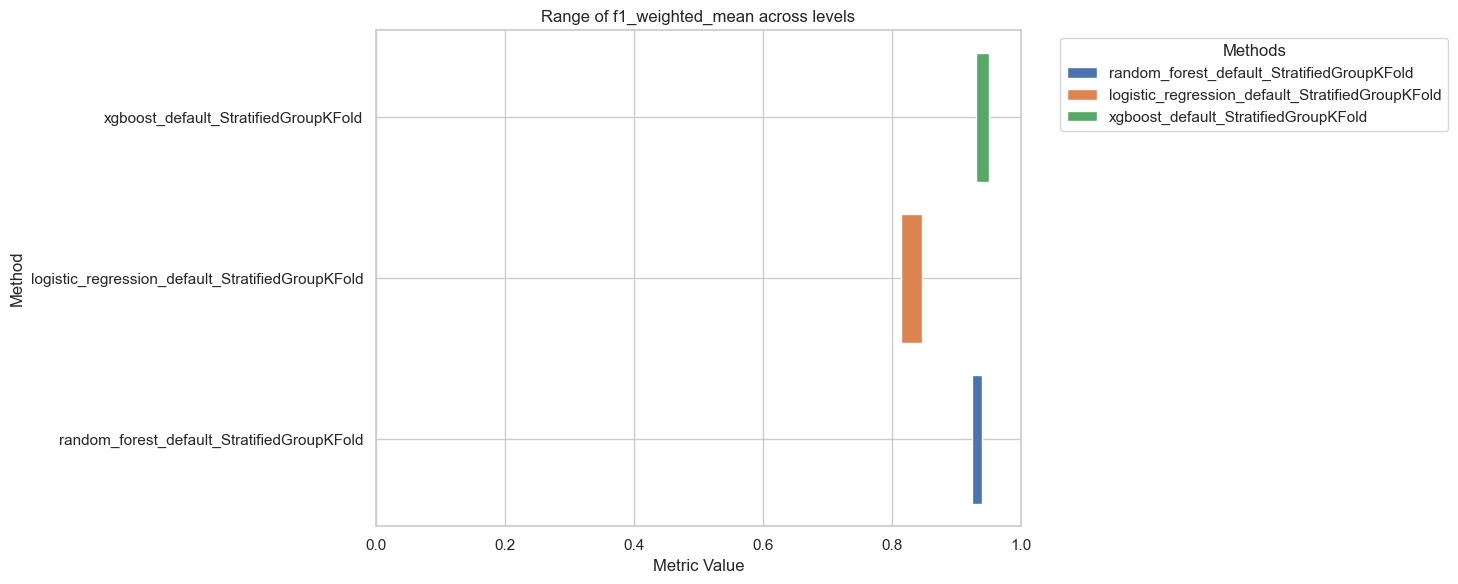

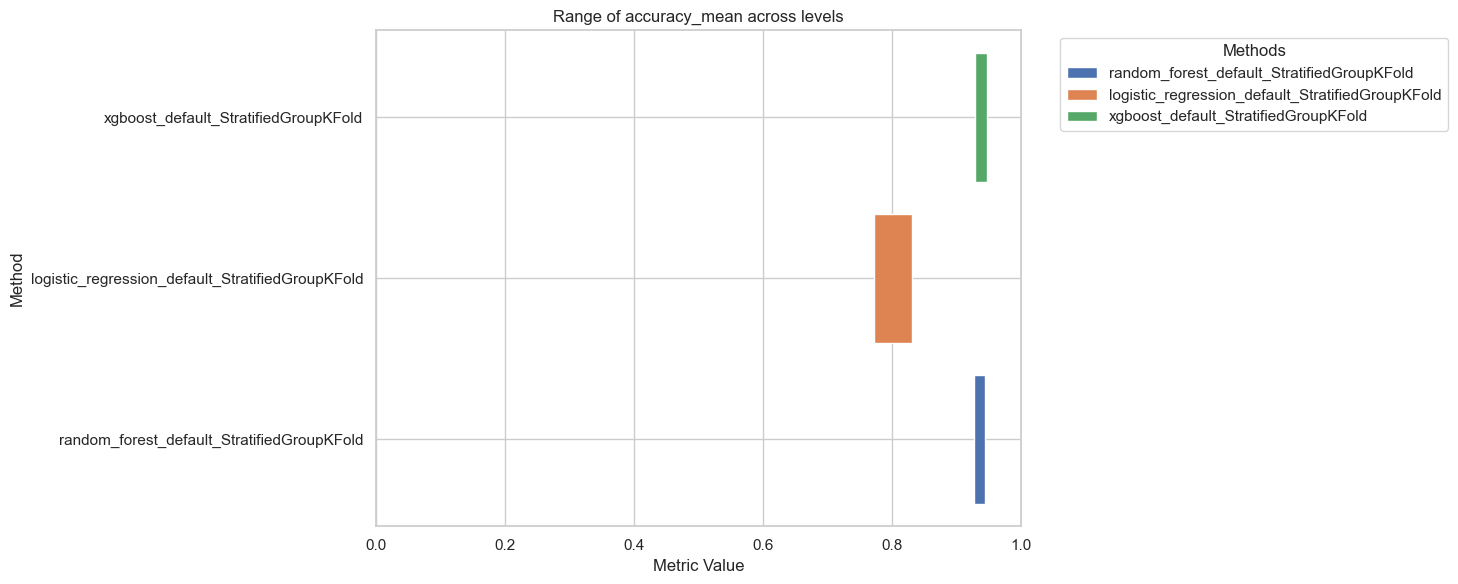

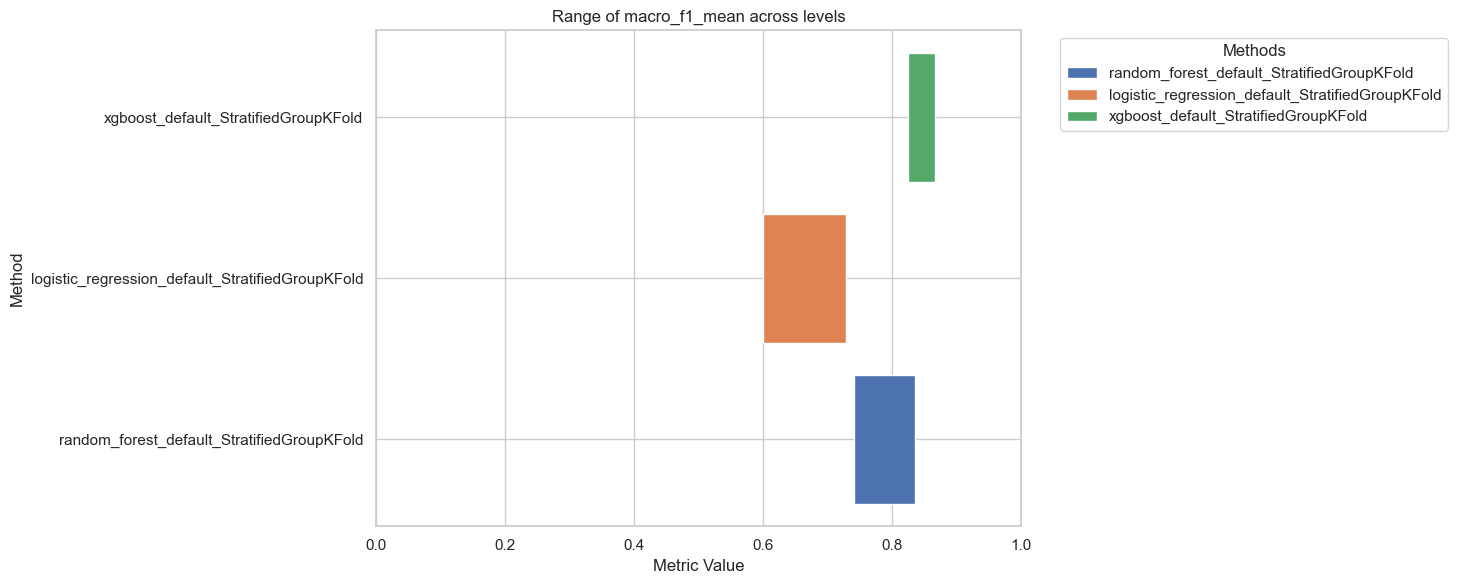

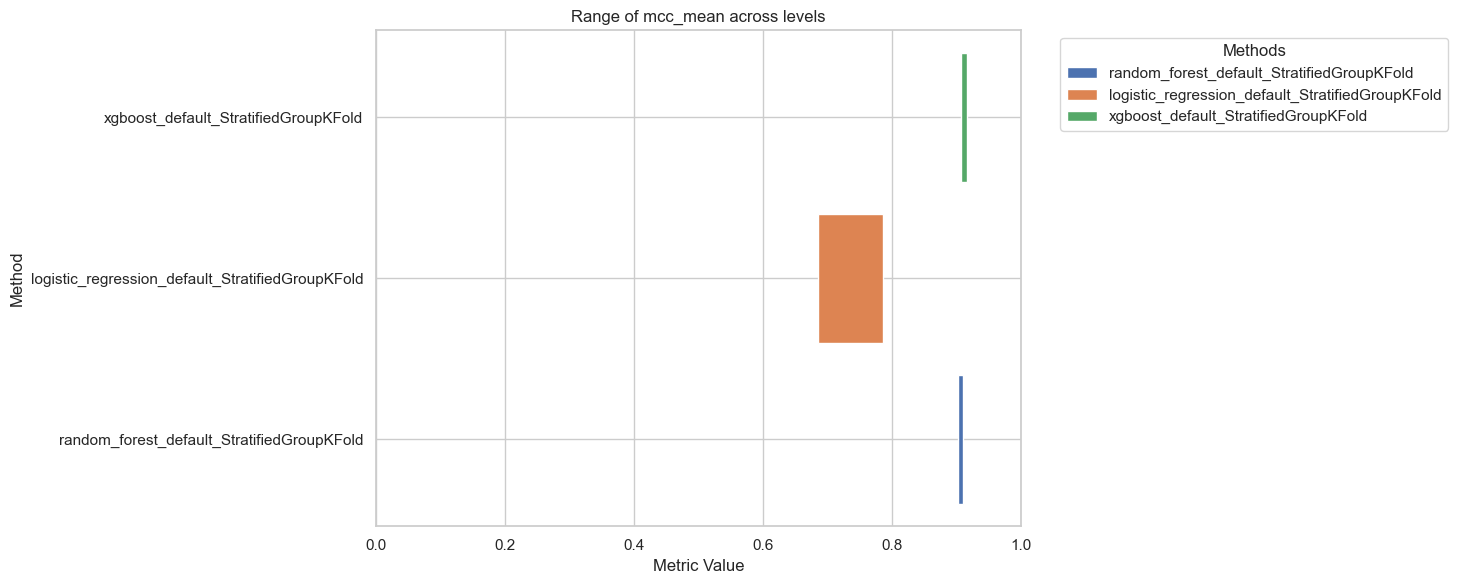

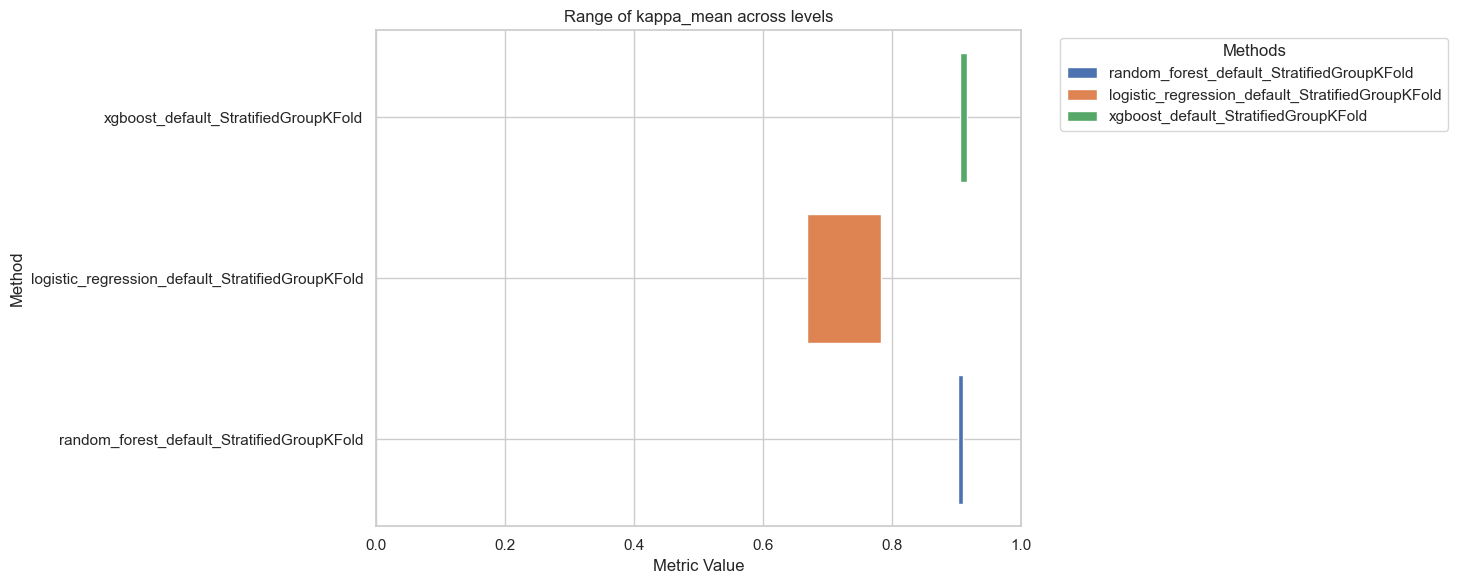

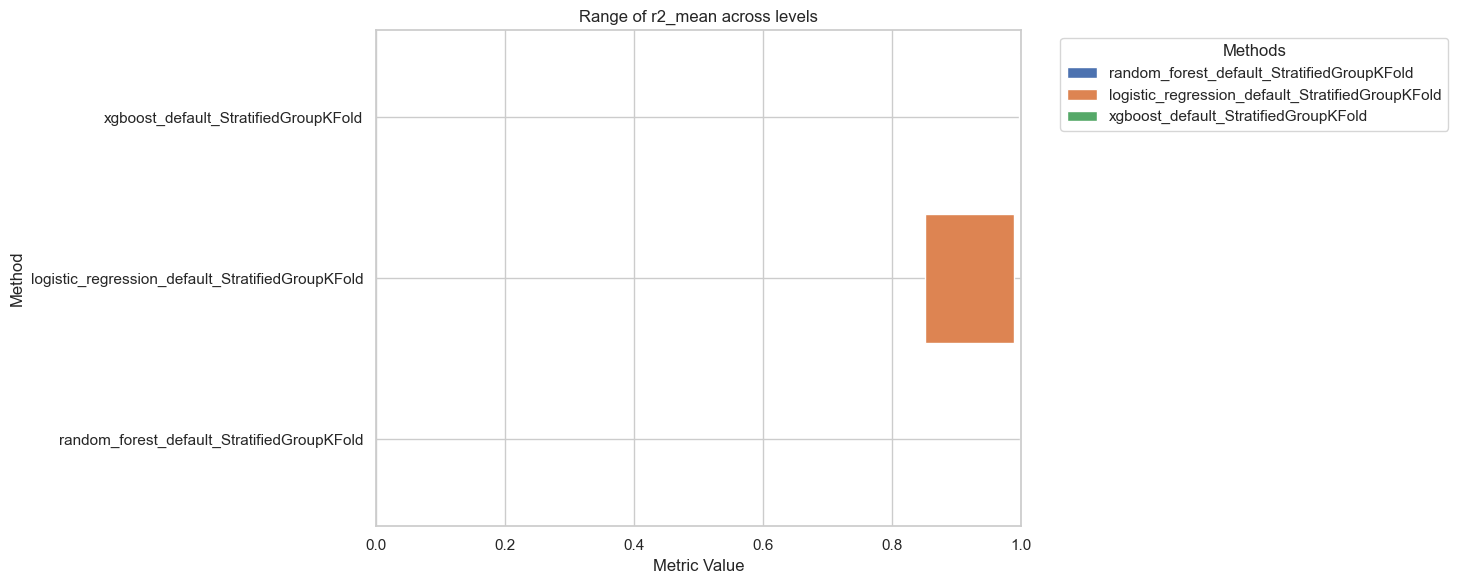

In [85]:
# Create horizontal bar plots for each metric
metrics = ['f1_weighted_mean', 'accuracy_mean', 'macro_f1_mean', 'mcc_mean', 'kappa_mean', 'r2_mean']

for metric in metrics:
    plt.figure(figsize=(15, 6))  # Increase the width of the figure
    for method in methods:
        method_data = final_results[final_results['method'] == method]
        min_value = method_data[metric].min()
        max_value = method_data[metric].max()
        plt.barh(method, max_value - min_value, left=min_value, label=method)
    
    plt.xlabel('Metric Value')
    plt.ylabel('Method')
    plt.title(f'Range of {metric} across levels')
    plt.xlim(0, 1)  # Scale the x-axis from 0 to 1
    plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

<Figure size 1500x800 with 0 Axes>

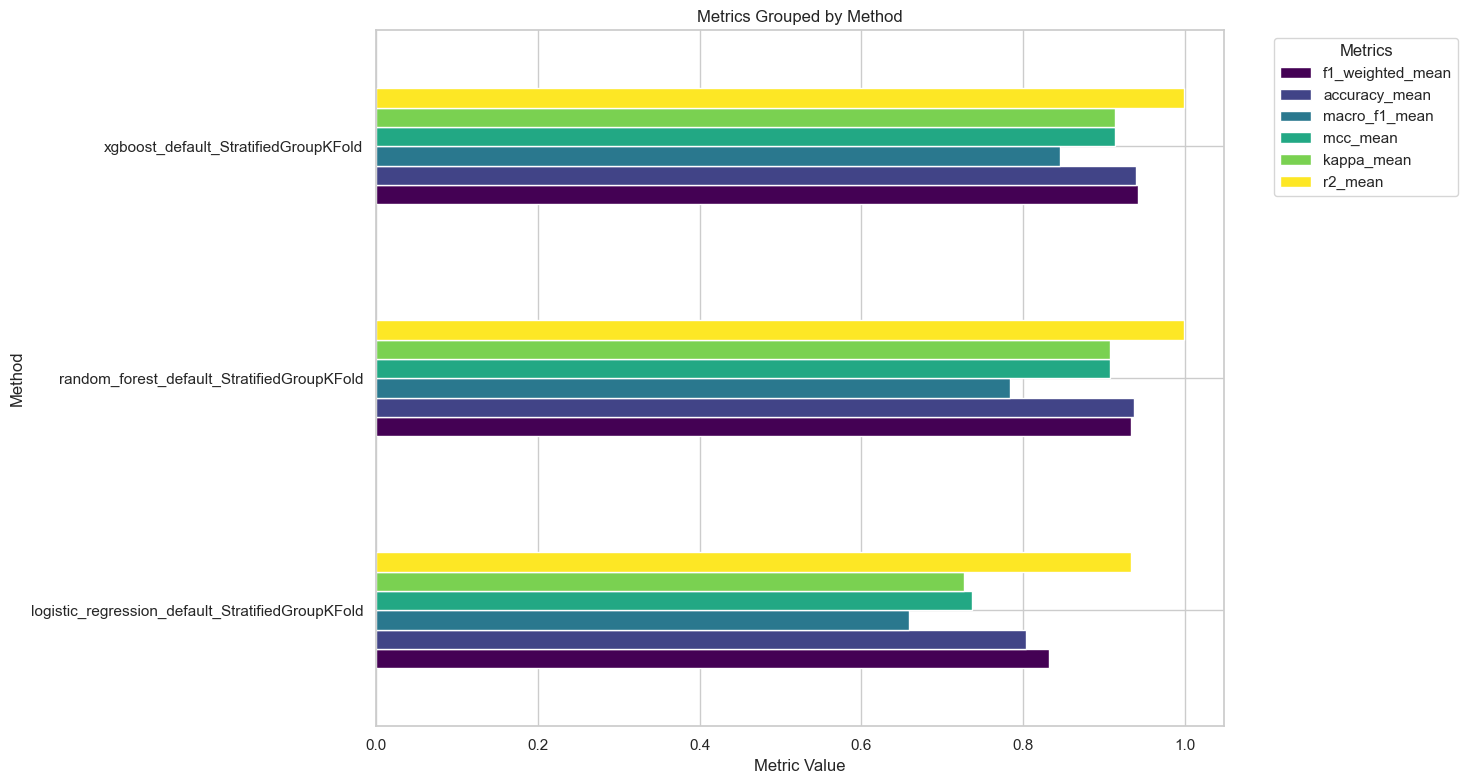

In [94]:
# Define the metrics to plot
metrics = ['f1_weighted_mean', 'accuracy_mean', 'macro_f1_mean', 'mcc_mean', 'kappa_mean', 'r2_mean']

# Set up the figure
plt.figure(figsize=(15, 8))

# Group the data by method and calculate the mean for each metric
grouped_data = final_results.groupby('method')[metrics].mean()

# Plot each metric grouped by method
grouped_data.plot(kind='barh', figsize=(15, 8), colormap='viridis')

# Add labels and title
plt.xlabel('Metric Value')
plt.ylabel('Method')
plt.title('Metrics Grouped by Method')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


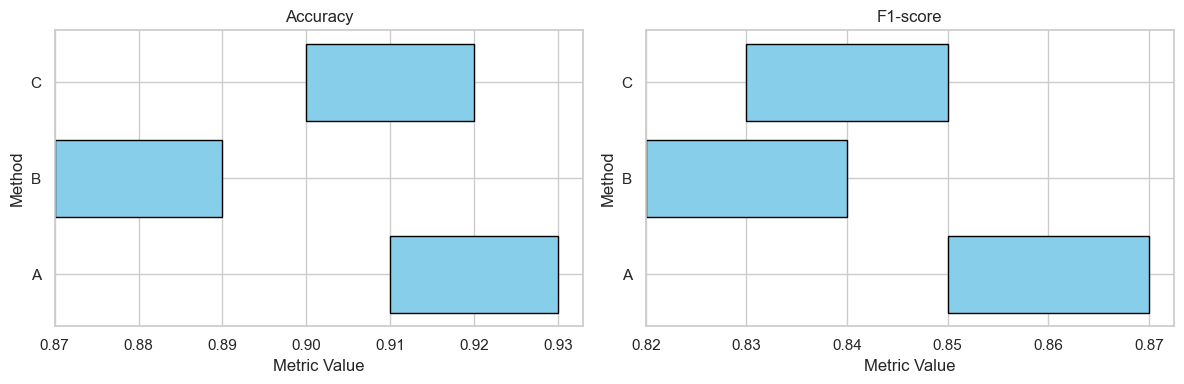

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample structured data
data = pd.DataFrame({
    'method': ['A']*3 + ['B']*3 + ['C']*3 +
              ['A']*3 + ['B']*3 + ['C']*3,
    'level': ['L1', 'L2', 'L3']*6,
    'metric': ['Accuracy']*9 + ['F1-score']*9,
    'value': [
        0.91, 0.93, 0.92, 0.88, 0.87, 0.89, 0.90, 0.91, 0.92,
        0.85, 0.86, 0.87, 0.82, 0.83, 0.84, 0.83, 0.84, 0.85
    ]
})

fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 4), sharex=False)

if len(metrics) == 1:
    axes = [axes]

for i, metric in enumerate(metrics):
    subset = summary[summary['metric'] == metric]
    for index, row in subset.iterrows():
        axes[i].barh(
            y=row['method'],
            width=row['max'] - row['min'],
            left=row['min'],
            color='skyblue',
            edgecolor='black'
        )
    axes[i].set_title(metric)
    axes[i].set_xlabel("Metric Value")
    axes[i].set_ylabel("Method")

plt.tight_layout()
plt.show()